<a href="https://colab.research.google.com/github/rcout328/Ai-saas/blob/main/scamsafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install torch torchvision numpy pandas scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Epoch [1/10], Loss: 0.6051
Epoch [3/10], Loss: 0.2670
Epoch [5/10], Loss: 0.2230
Epoch [7/10], Loss: 0.0692
Epoch [9/10], Loss: 0.0731


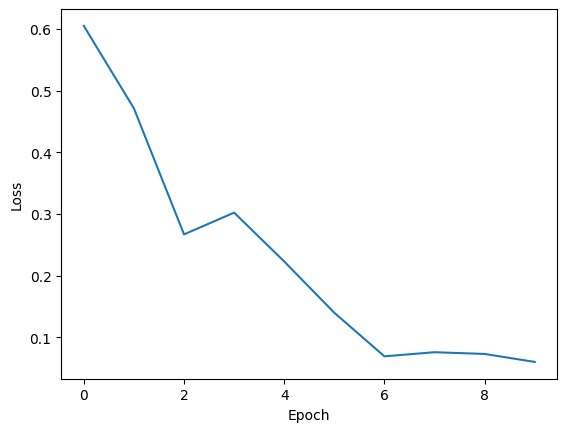

Accuracy: 0.5500
The message is classified as: scam


In [20]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam3.csv', encoding='latin-1')
data
# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size, h1=64, h2=32, out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 10
losses = []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    if epoch % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')


def preprocess_message(message, vectorizer):
    message_vectorized = vectorizer.transform([message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

# Make a prediction
def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

# Interpret the prediction
def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Example message
new_message = "Hi, you have won a prize worth $1,500. kindly claim your prize using the link below https://luckywinner.online/"

# Preprocess the message
message_tensor = preprocess_message(new_message, vectorizer)

# Get the prediction
prediction = predict_message(model, message_tensor)

# Interpret the prediction
result = interpret_prediction(prediction)

print(f"The message is classified as: {result}")